In [1]:
from tqdm import tqdm
# from itertools import batched
import torch
# load mnist dataset
from torchvision import datasets, transforms

mps_device = torch.device("cpu")
# mps_device = torch.device("mps")

In [2]:
dataset = datasets.MNIST("../../data", train=True, download=True, transform=transforms.ToTensor())

#  extract dataset into tensors of X and y
X = dataset.data
X = X.reshape(X.shape[0], -1) # flatten the images 

X = X / 255.0 # normalize the images

# X = X > 1/2 # binarize the images
# X = X.to(torch.float32) # convert to float32

y = dataset.targets# / 1.0 # labels

X = X.to(mps_device)
y = y.to(mps_device)

X.shape, y.shape

# split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([45000, 784]),
 torch.Size([45000]),
 torch.Size([15000, 784]),
 torch.Size([15000]))

In [3]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(negative_slope=0.5),
            nn.Linear(512, 10),
            nn.LeakyReLU(negative_slope=0.5),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
model = NeuralNetwork().to(mps_device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [5]:
from sklearn.metrics import accuracy_score
# training loop

# first we need to generate batches of the training data
# we do this manually for clarity, and not using the dataloader

batch_size = 64
n_epochs = 500

n_samples = X_train.shape[0]
n_batches = n_samples // batch_size

# save the original weights
origninal_weights = model.state_dict()

for epoch in range(n_epochs):
    # print(f"Epoch {epoch+1}/{n_epochs} ", end="")
    log_size = 0
    for i in range(n_batches):
        # generate a batch
        start = i * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

    
        # forward pass
        y_pred = model(X_batch)

        # compute loss
        loss = loss_fn(y_pred, y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        log_msg = f"Batch {i+1}/{n_batches} loss: {loss.item():.4f}"
        print(f"Epoch {epoch+1}/{n_epochs}", log_msg, end="\r")

    # after each epoch, evaluate the model
    # by computing the loss and accuracy on the test set

    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} ", end="| ")
        y_pred = model(X_test)
        y_pred = y_pred.squeeze()
        loss = loss_fn(y_pred, y_test)
        print(f"Test loss: {loss.item():.4f}", end=" | ")

        y_pred = torch.argmax(y_pred, dim=1)
        # y_pred = y_pred
        acc = accuracy_score(y_test, y_pred)
        print(f"Test accuracy: {acc:.4f}")

    # with torch.no_grad():
    #     print(f"Epoch {epoch+1}/{n_epochs} ", end="| ")
    #     y_pred = model(X_test)
    #     y_pred = y_pred.squeeze()
    #     loss = loss_fn(y_pred, y_test)
    #     print(f"Test loss: {loss.item():.4f}", end=" | ")

    #     # y_pred = torch.argmax(y_pred, dim=1)
    #     y_pred = y_pred.round()
    #     acc = accuracy_score(y_test, y_pred)
    #     print(f"Test accuracy: {acc:.4f}")

Epoch 1/500 | tch 703/703 loss: 0.7357Test loss: 0.6902 | Test accuracy: 0.8437
Epoch 2/500 | Test loss: 0.4666 | Test accuracy: 0.8760
Epoch 3/500 | Test loss: 0.3999 | Test accuracy: 0.8885
Epoch 4/500 | Test loss: 0.3673 | Test accuracy: 0.8956
Epoch 5/500 | Test loss: 0.3475 | Test accuracy: 0.8996
Epoch 6/500 | Test loss: 0.3337 | Test accuracy: 0.9030
Epoch 7/500 | Test loss: 0.3234 | Test accuracy: 0.9060
Epoch 8/500 | Test loss: 0.3152 | Test accuracy: 0.9087
Epoch 9/500 | tch 703/703 loss: 0.3024Test loss: 0.3085 | Test accuracy: 0.9105
Epoch 10/500 | Test loss: 0.3028 | Test accuracy: 0.9117
Epoch 11/500 | Test loss: 0.2978 | Test accuracy: 0.9137
Epoch 12/500 | Test loss: 0.2934 | Test accuracy: 0.9151
Epoch 13/500 | Test loss: 0.2895 | Test accuracy: 0.9166
Epoch 14/500 | Test loss: 0.2859 | Test accuracy: 0.9179
Epoch 15/500 | Test loss: 0.2825 | Test accuracy: 0.9192
Epoch 16/500 | Test loss: 0.2794 | Test accuracy: 0.9195
Epoch 17/500 | Test loss: 0.2765 | Test accuracy:

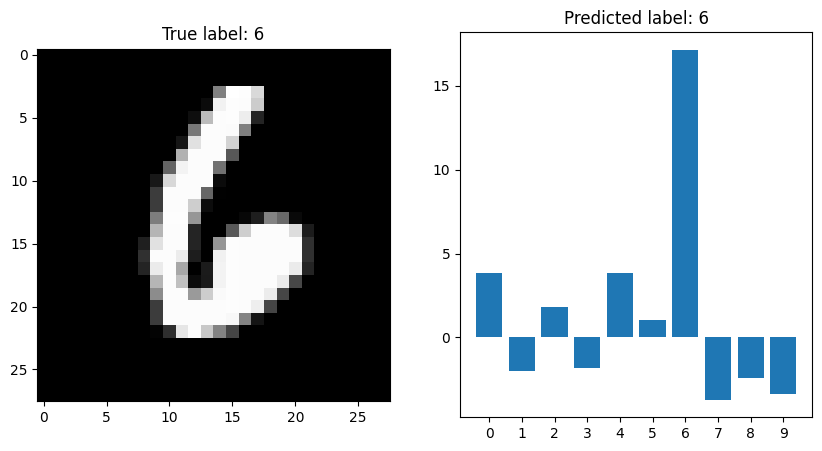

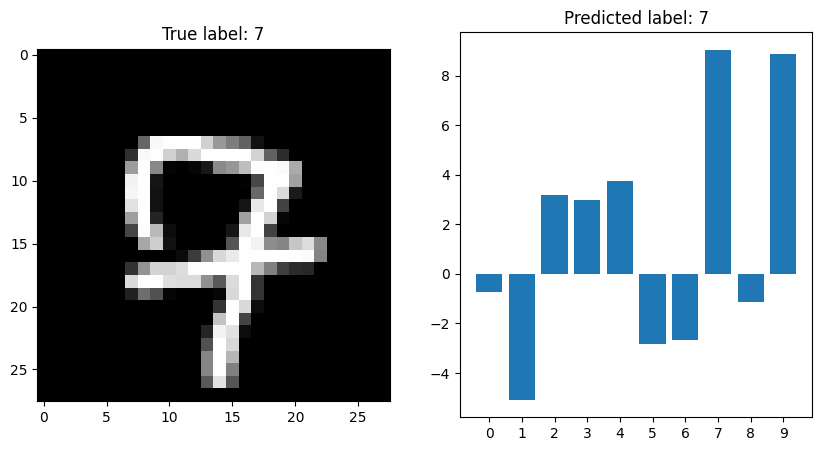

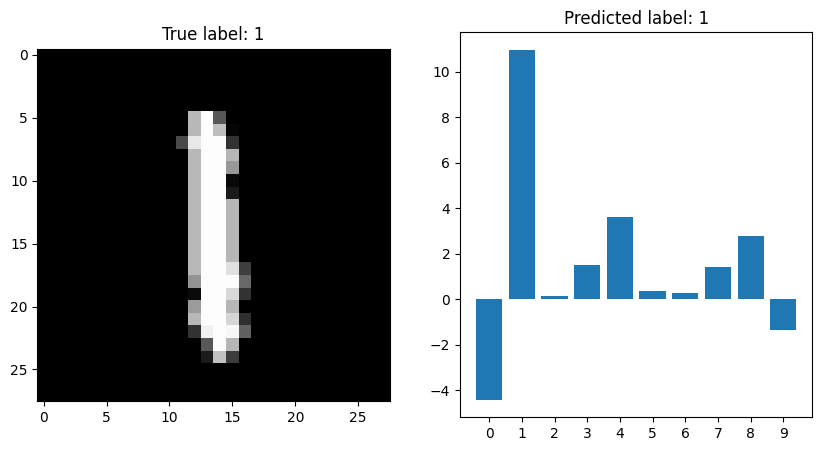

In [6]:
import random

import matplotlib.pyplot as plt
%matplotlib inline

for _ in range(3):
    # get the image and its label at index, and predict the label
    # then, plot the image and print the prediction
    index = random.randint(0, X_test.shape[0])

    image = X_test[index].reshape(28, 28)
    label = y_test[index]

    with torch.no_grad():
        pred = model(X_test[index])
        pred_max = torch.argmax(pred)


    # Now, we want to plot the image
    # but also the probabilities of each class
    # from the `pred` tensor (pred is already the output of the model)
    # lets do it on the same figure

    # create figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # plot the image
    ax1.imshow(image, cmap="gray")
    ax1.set_title(f"True label: {label}")

    # plot the probabilities
    ax2.bar(range(10), pred.numpy())
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(range(10))
    ax2.set_title(f"Predicted label: {pred_max}")



In [7]:
d = {}
for layer in model.state_dict():
    converted = model.state_dict()[layer].numpy().tolist()
    d[layer] = converted

import json
with open("mnist_weights.json", "w") as f:
    json.dump(d, f, indent=4)

In [8]:
# goal is to print the weights as a 2d c++ vector
# so i can copy paste it into the code
print("weights = {")
for row in origninal_weights["linear_relu_stack.0.weight"]:
    vec = [f"{x:.4f}" for x in row]
    print(f"{{{', '.join(vec)}}},")
print("}")

weights = {
{-0.0112, -0.0277, -0.0028, 0.0104, 0.0348, -0.0330, 0.0307, -0.0059, 0.0280, -0.0000, 0.0277, -0.0309, -0.0062, 0.0270, 0.0244, 0.0205, -0.0151, -0.0185, -0.0206, 0.0072, -0.0058, 0.0195, 0.0029, 0.0175, 0.0234, -0.0350, 0.0333, -0.0247, -0.0135, 0.0235, -0.0034, -0.0057, 0.0043, 0.0072, -0.0060, -0.0191, 0.0100, -0.0317, 0.0114, 0.0286, -0.0309, -0.0261, -0.0318, 0.0269, -0.0066, 0.0211, -0.0239, 0.0139, -0.0221, -0.0162, -0.0016, 0.0328, 0.0250, 0.0082, 0.0125, -0.0193, 0.0174, 0.0176, 0.0269, 0.0218, 0.0224, 0.0250, -0.0293, 0.0246, 0.0188, -0.0043, 0.0042, -0.0092, 0.0105, 0.0030, 0.0165, 0.0026, 0.0184, 0.0188, 0.0181, 0.0086, 0.0345, 0.0137, -0.0246, 0.0075, 0.0241, 0.0099, -0.0017, -0.0003, -0.0293, 0.0133, 0.0161, 0.0231, -0.0231, -0.0039, 0.0353, -0.0143, 0.0393, 0.0263, -0.0012, -0.0049, 0.0293, 0.0071, -0.0020, -0.0020, 0.0360, -0.0073, -0.0492, -0.0383, 0.0046, -0.0049, 0.0269, -0.0223, 0.0314, 0.0066, 0.0026, 0.0299, -0.0024, 0.0307, 0.0244, 0.0138, -0.0219, 0

In [9]:
# now lets do the same for the biases
print("vector<double> biases = {")
vec = [f"{x:.4f}" for x in origninal_weights["linear_relu_stack.0.bias"]]
print(f"{', '.join(vec)},")
print("}")

vector<double> biases = {
-0.0357, -0.0215, -0.0904, 0.0298, 0.0604, 0.0151, -0.0219, -0.0127, 0.0705, 0.0583, -0.0316, 0.0780, -0.0128, -0.0418, -0.1052, 0.0621, 0.0150, 0.0746, -0.0154, -0.0300, 0.0261, 0.0504, 0.0570, 0.0962, 0.0870, 0.1074, 0.0831, -0.0513, 0.0316, 0.0085, -0.0089, 0.0290, 0.0291, 0.0330, -0.0368, -0.0074, -0.0163, 0.0743, 0.0565, -0.0741, -0.0545, -0.0053, -0.0782, -0.0741, -0.0685, -0.0290, 0.0281, 0.0204, 0.0307, -0.0274, 0.0328, 0.0586, -0.0563, -0.0283, 0.0053, 0.1029, -0.0414, 0.0669, 0.0425, -0.0183, -0.0716, -0.0405, 0.0393, -0.0581, 0.0036, 0.0052, 0.0233, -0.0088, 0.0506, 0.0459, -0.0320, -0.0167, 0.0616, -0.0020, -0.0119, -0.0132, 0.0020, 0.0893, -0.0285, -0.1146, 0.0192, -0.0025, -0.0862, 0.0227, -0.0365, 0.0216, 0.0594, 0.0231, -0.0134, -0.0877, 0.0572, -0.0959, -0.0316, -0.0271, 0.0352, 0.0780, 0.0590, -0.0119, 0.0451, -0.1693, -0.0432, 0.0777, -0.0447, 0.0531, 0.0700, -0.0651, -0.0877, 0.0013, 0.0070, 0.0621, 0.0469, -0.0196, 0.0394, 0.0011, -0.0010,